In [ ]:
# All the necesarry libraries
import pandas as pd
import zipfile
import os
import random
import torch
from ultralytics import YOLOWorld
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision import models
from IPython.display import display
from ultralytics import YOLO
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
from dotenv import load_dotenv
print(torch.cuda.is_available())  # Trebuie să returneze True
print(torch.cuda.get_device_name(0))  # Trebuie să afișeze numele GPU-ului

True
NVIDIA GeForce RTX 3050 Laptop GPU


In [ ]:
# Define paths
root_dir = os.getenv('ROOT_FOlDER')
v1_dir = os.path.join(root_dir, 'echipamente')

Displaying some training images from version 1:


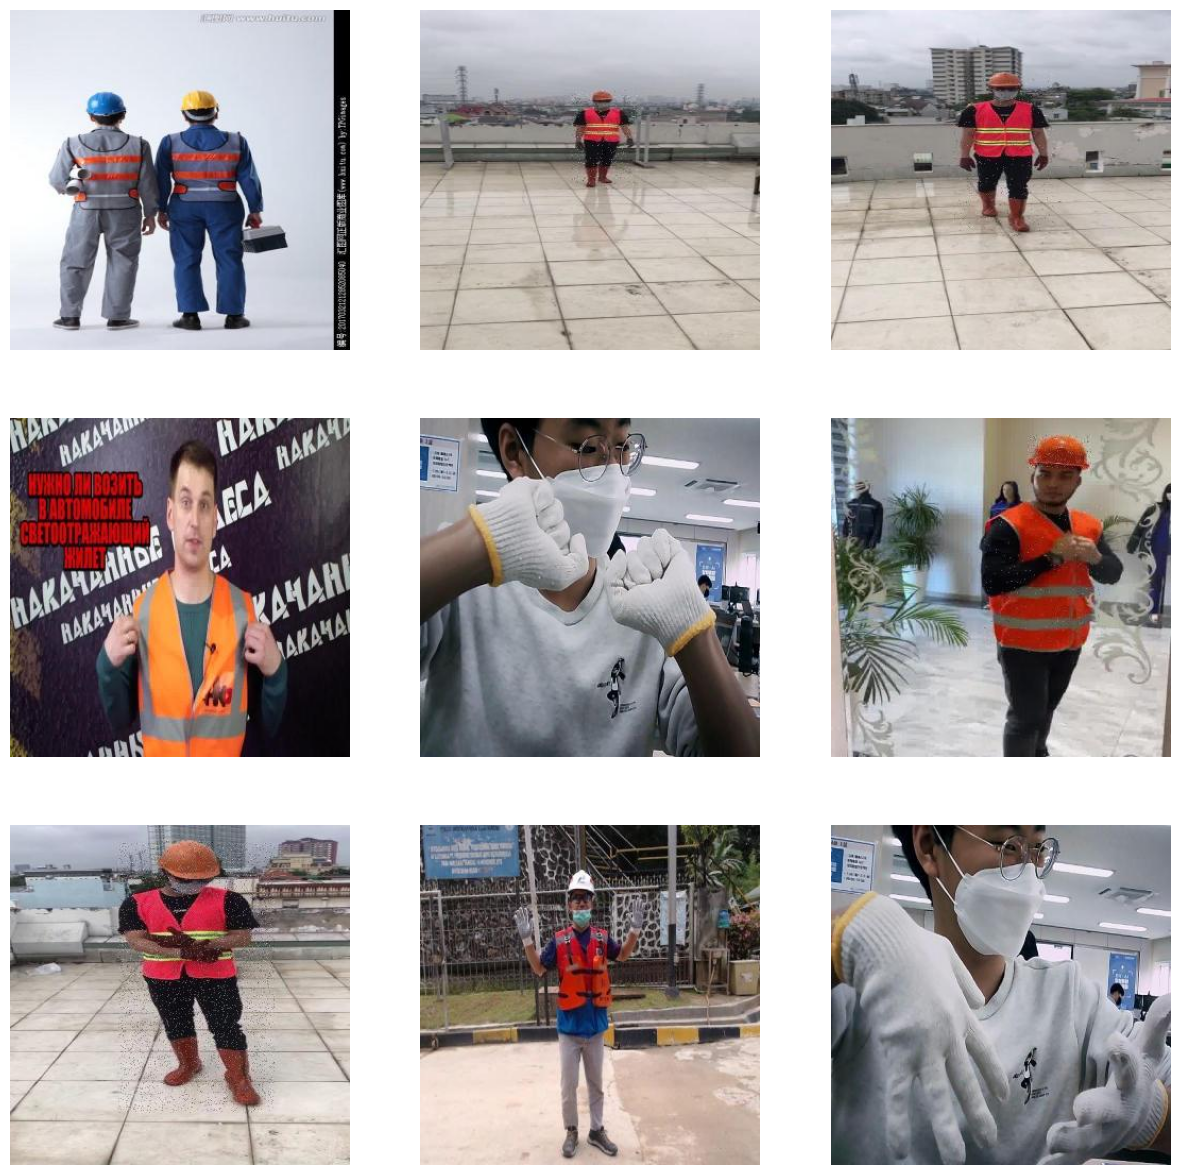

In [3]:
# Function to display images, modify num_images to show how much images you want
def display_images(image_dir, num_images=9):
    images = os.listdir(image_dir)
    sample_images = random.sample(images, num_images)
    plt.figure(figsize=(15, 15))
    for i, image_name in enumerate(sample_images):
        image_path = os.path.join(image_dir, image_name)
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(3, 3, i + 1)
        plt.imshow(img_rgb)
        plt.axis('off')
    plt.show()

# Display some training images
print("Displaying some training images from version 1:")
display_images(os.path.join(v1_dir, 'train/images'))

In [ ]:
def update_data_yaml(data_yaml_path, base_dir):

    data_yaml_path = os.path.expanduser(data_yaml_path)
    base_dir = os.path.expanduser(base_dir)

    # Read file data.yaml
    with open(data_yaml_path, 'r') as file:
        data_yaml = file.read()

    # update file paths
    data_yaml = data_yaml.replace('../train/images', os.path.join(base_dir, 'train/images'))
    data_yaml = data_yaml.replace('../valid/images', os.path.join(base_dir, 'valid/images'))
    data_yaml = data_yaml.replace('../test/images', os.path.join(base_dir, 'test/images'))

    # Write updates
    with open(data_yaml_path, 'w') as file:
        file.write(data_yaml)

# paths
data_yaml_path = os.getenv('YAML_FILE')
base_dir = os.getenv('BASE_DIR')
# Update file data.yaml
update_data_yaml(data_yaml_path, base_dir)

# Check results
def print_data_yaml(data_yaml_path):
    data_yaml_path = os.path.expanduser(data_yaml_path)
    with open(data_yaml_path, 'r') as file:
        print(file.read())

print("Updated data.yaml:")
print_data_yaml(data_yaml_path)

In [6]:
import gc
gc.collect()

15273

In [7]:
# EDA and Preprocessing
def load_labels(label_dir):
    label_files = os.listdir(label_dir)
    data = []
    for label_file in label_files:
        with open(os.path.join(label_dir, label_file), 'r') as file:
            lines = file.readlines()
            for line in lines:
                class_id, x_center, y_center, width, height = map(float, line.strip().split())
                data.append([label_file, class_id, x_center, y_center, width, height])
    df = pd.DataFrame(data, columns=['file', 'class_id', 'x_center', 'y_center', 'width', 'height'])
    return df

v1_train_labels = load_labels(os.path.join(v1_dir, 'train/labels'))
v1_valid_labels = load_labels(os.path.join(v1_dir, 'valid/labels'))
v1_test_labels = load_labels(os.path.join(v1_dir, 'test/labels'))

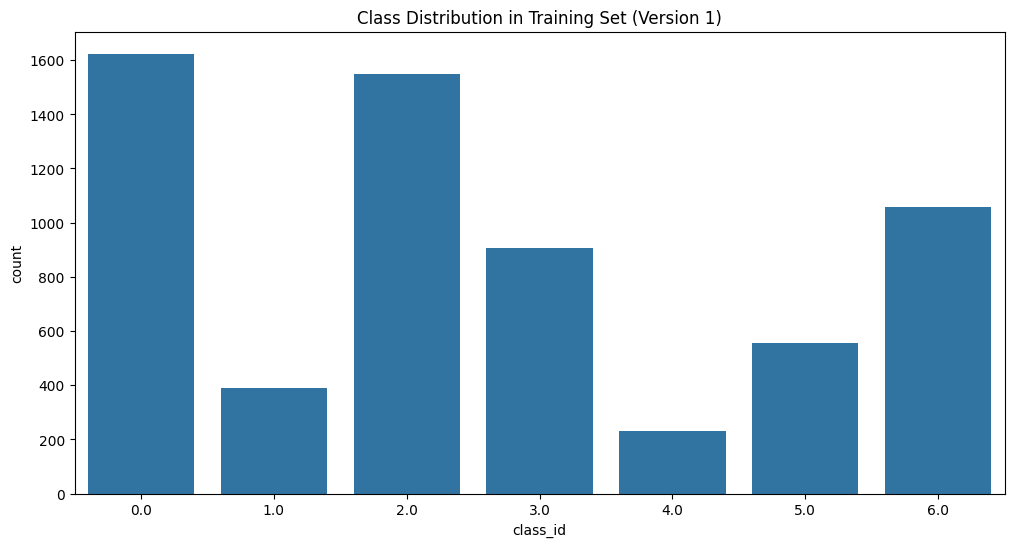

In [10]:
# Plot class distribution
plt.figure(figsize=(12, 6))
sns.countplot(data=v1_train_labels, x='class_id')
plt.title('Class Distribution in Training Set (Version 1)')
plt.show()

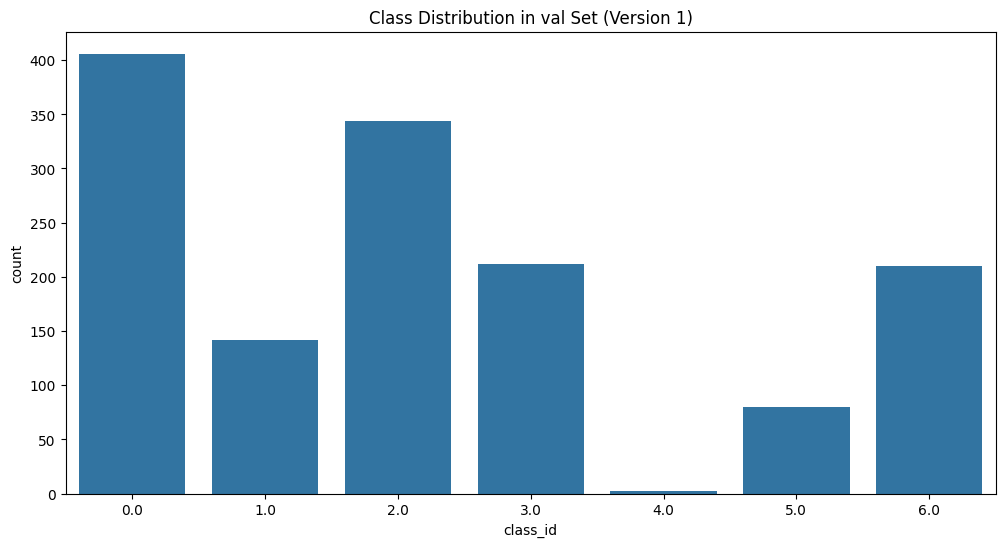

In [11]:
# Plot class distribution
plt.figure(figsize=(12, 6))
sns.countplot(data=v1_valid_labels, x='class_id')
plt.title('Class Distribution in val Set (Version 1)')
plt.show()

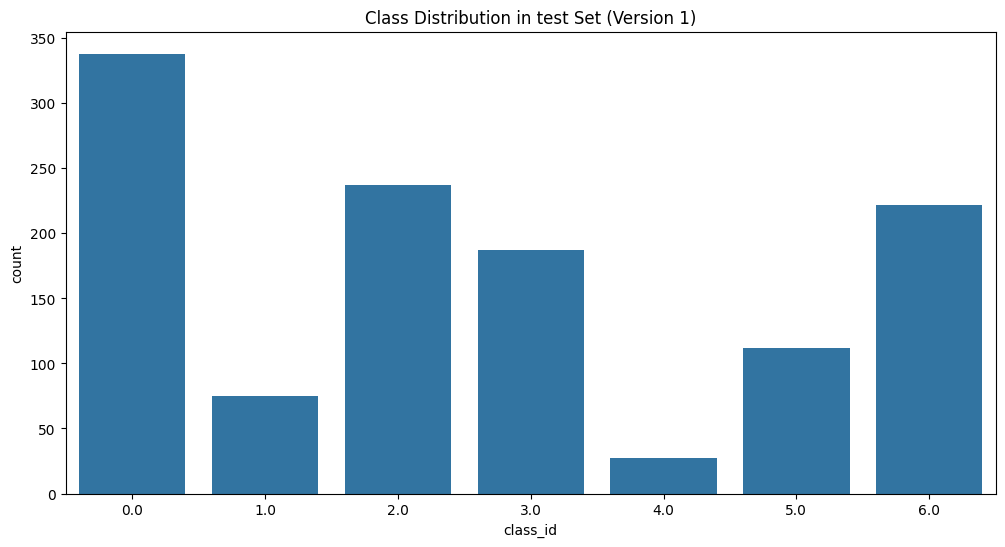

In [12]:
# Plot class distribution
plt.figure(figsize=(12, 6))
sns.countplot(data=v1_test_labels, x='class_id')
plt.title('Class Distribution in test Set (Version 1)')
plt.show()

In [10]:
from ultralytics import YOLO
model = YOLO('yolov8m.pt')

100%|██████████| 49.7M/49.7M [00:06<00:00, 7.50MB/s]


In [ ]:
results = model.train(data=data_yaml_path, epochs=100, imgsz=640, device = 0, workers= 8, batch = 16)

In [ ]:
import os
import random
import cv2
import matplotlib.pyplot as plt
from PIL import Image

def display_results(model, img_dir, num_images=12, conf_threshold=0.25, save_dir='runs/detect/exp'):
    """
    Evaluate the model and display results with comprehensive visualization

    Args:
        model: Trained YOLO model
        img_dir: Directory containing test images
        num_images: Number of random images to process
        conf_threshold: Confidence threshold for detections
        save_dir: Directory to save result images
    """
    # Ensure save directory exists
    os.makedirs(save_dir, exist_ok=True)

    # Filter valid image files
    valid_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tif']
    images = [f for f in os.listdir(img_dir) if os.path.splitext(f)[1].lower() in valid_extensions]

    # Randomly sample images
    sample_images = random.sample(images, min(num_images, len(images)))

    # Prepare subplot grid
    fig, axes = plt.subplots(3, 4, figsize=(20, 15))
    axes = axes.ravel()

    for idx, image_name in enumerate(sample_images):
        # Construct full image path
        image_path = os.path.join(img_dir, image_name)

        try:
            # Perform inference with confidence threshold
            results = model(image_path, conf=conf_threshold)

            # Plot and save results
            for result in results:
                # Save annotated image
                result_path = os.path.join(save_dir, f'result_{image_name}')
                result.save(result_path)

                # Read the annotated image
                img = cv2.imread(result_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                # Display on subplot
                axes[idx].imshow(img)
                axes[idx].set_title(f'Detections: {image_name}')
                axes[idx].axis('off')

                # Print detection details
                print(f"\nDetections in {image_name}:")
                if len(result.boxes) > 0:
                    for box in result.boxes:
                        cls = int(box.cls[0])
                        conf = float(box.conf[0])
                        print(f"  - {model.names[cls]}: Confidence {conf:.2f}")
                else:
                    print("  No detections found")

        except Exception as e:
            print(f"Error processing {image_name}: {e}")
            # Display a blank or error image if processing fails
            axes[idx].text(0.5, 0.5, f'Error: {e}',
                            horizontalalignment='center',
                            verticalalignment='center')
            axes[idx].axis('off')

    # Adjust layout and display
    plt.tight_layout()
    plt.show()

# Usage example
print("Displaying results from model trained on version 1 with augmentation:")
display_results(
    model,
    os.path.join(v1_dir, 'test/images'),
    num_images=12,  # Adjust number of images to display
    conf_threshold=0.25  # Adjust confidence threshold
)